In [2]:
# Numpy change it's output behavior;
# now it prints the type like np.float(0.0)
import numpy as np
# np.set_printoptions(legacy="1.25")
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

from pathlib import Path

import gudhi as gd
from gudhi import bottleneck_distance
from gudhi.hera.wasserstein import wasserstein_distance

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns

import networkx as nx
import numpy as np
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs

import time
from grammodels.representations import Treegrams, Cliquegram, Facegram,\
    format_mergegram, compare_mergegrams
from grammodels.simplexdiagram import CriticalSimplexDiagram

from grammodels.facegram import facegram_alg1, facegram_alg2
from grammodels.create_data import create_random_similar_trees
from grammodels.representations import format_mergegram, Cliquegram,\
    facegram_from_simplexTree

In [4]:
def sort_dict_by_entries(mydict):
    sorted_dict = dict(sorted(mydict.items(), key=lambda item: (item[1][0], item[1][1], item[0])))
    return sorted_dict

# Critical simplex diagram

Let us use the critical simplex diagram implementation (1) to plot the DAG associated to the treegram (hence a dendrogram)

In [6]:
treedistance1 = np.array([
    [0, 2, 3, 3, 3],
    [2, 0, 3, 3, 3],
    [3, 3, 0, 1, 3],
    [3, 3, 1, 0, 3],
    [3, 3, 3, 3, 0]
])
treedistance2 = np.array([
    [0, 4, 1, 4, 4],
    [4, 0, 4, 3, 1],
    [1, 4, 0, 4, 4],
    [4, 3, 4, 0, 3],
    [4, 1, 4, 3, 0]
])

treedistances = [treedistance1, treedistance2]
treegrams_cl = Treegrams(treedistances=treedistances)
mgm_trees = treegrams_cl.compute_labelled_mergegram()

treegrams = [sort_dict_by_entries(td) for td in treegrams_cl.treegramslist]

<class 'dict'> True


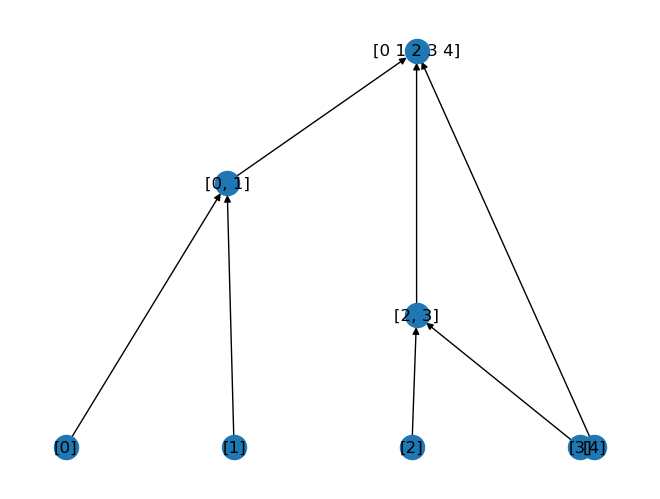

In [7]:
model = treegrams[0]
taxa = np.arange(5)

filtrations = np.unique([td[i] for td in model.values() for i in range(2)])[:-1]
M = [[key for key in model.keys() if model[key][0] == filt] for filt in filtrations]

csd = CriticalSimplexDiagram(taxa=np.arange(5), filtration=filtrations)
for cells, filtval in zip(M, filtrations[:len(M)]):
    if len(cells) == 1 and sorted(cells[0]) == sorted(taxa):
        continue
    csd.add_critical_nodes(criticalcells=cells, filtration_value=filtval)

csd.plot_graph()

<class 'dict'> True


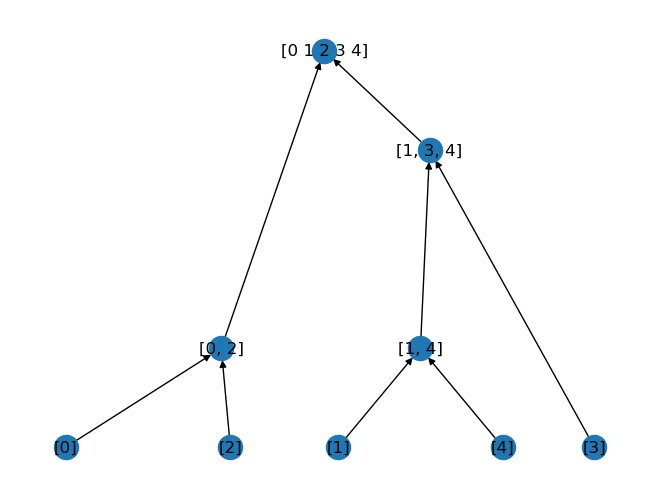

In [8]:
model = treegrams[1]
taxa = np.arange(5)

filtrations = np.unique([td[i] for td in model.values() for i in range(2)])[:-1]
M = [[key for key in model.keys() if model[key][0] == filt] for filt in filtrations]

csd = CriticalSimplexDiagram(taxa=np.arange(5), filtration=filtrations)
for cells, filtval in zip(M, filtrations[:len(M)]):
    if len(cells) == 1 and sorted(cells[0]) == sorted(taxa):
        continue
    csd.add_critical_nodes(criticalcells=cells, filtration_value=filtval)

csd.plot_graph()

# Use facegram for general filtrations

In this case we use the alpha complex, and do not include anything above the maximal cliques in the facegram.
Hence, the mergegram will contain a lot of points with infinite lifetime.

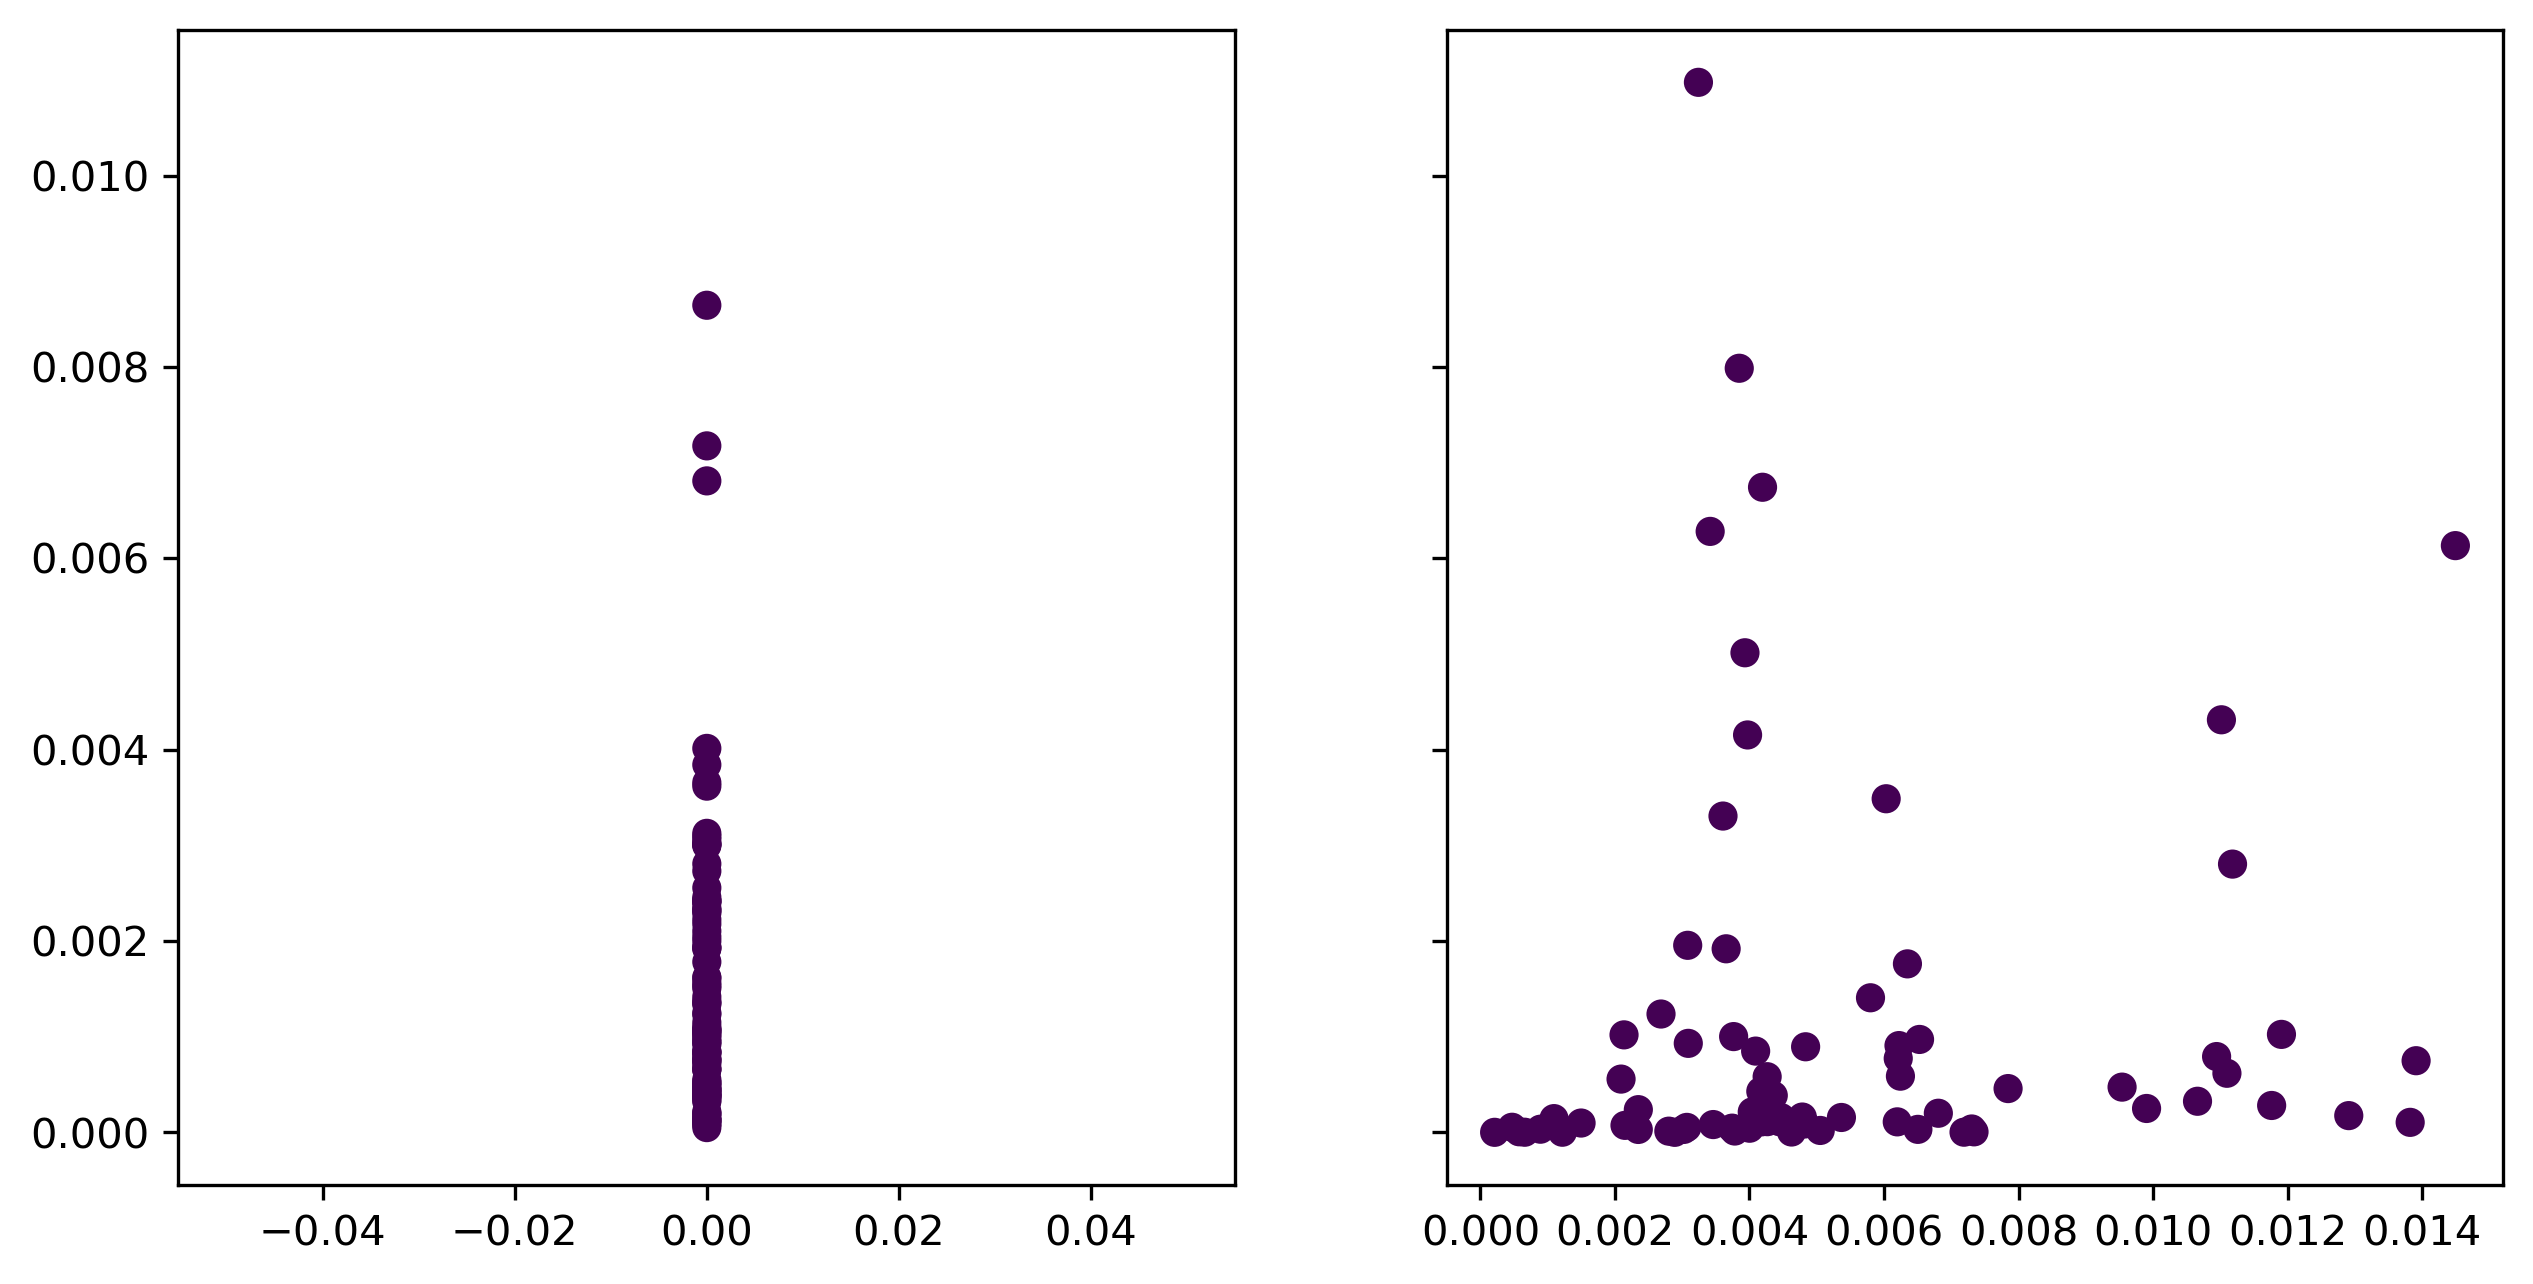

In [3]:
X = np.random.random((100, 2))

alpha = gd.AlphaComplex(points=X).create_simplex_tree()
alpha.compute_persistence()

fig, ax = plt.subplots(1,2, dpi=300, figsize=(10,5), sharey=True)

for i in range(2):
    pers, count = np.unique(alpha.persistence_intervals_in_dimension(i), return_counts=True, axis=0)
    ax[i].scatter(pers[:,0], pers[:,1]-pers[:,0], c=count)

In [4]:
mergegram = facegram_from_simplexTree(alpha, num_taxa=np.shape(X)[0], tqdm_disable=False)

100%|██████████| 565/565 [00:00<00:00, 134242.44it/s]


In [5]:
# we can also do an excessive approach by going through all simplices
# and checking all the cofaces of codimension 1 and picking the one with
# the smallest filtration value

mergegram_direct = []
maxf = 0
for simplex, fvalue in tqdm(alpha.get_filtration()):
    if maxf < fvalue:
        maxf = fvalue
    death = [x[1] for x in alpha.get_cofaces(simplex, 1)]
    if len(death) > 0:
        death = min(death)
        if fvalue < death:
            mergegram_direct.append((fvalue, death))
    else:
        # here we do not have the full complex X, so we need to add it
        mergegram_direct.append((fvalue, np.inf))

0it [00:00, ?it/s]

In [6]:
mgm = format_mergegram(mergegram, delete_infinite=False)
mgm_direct = format_mergegram(mergegram_direct, delete_infinite=False)

print('Are these two mergegrams the same?', np.all(mgm == mgm_direct))

Are these two mergegrams the same? True


We can see that the persistence diagram of the mergegram seems to look a bit similar to a combination of the 0-dim and 1-dim persistence diagrams of the alpha complex (they are different though!).

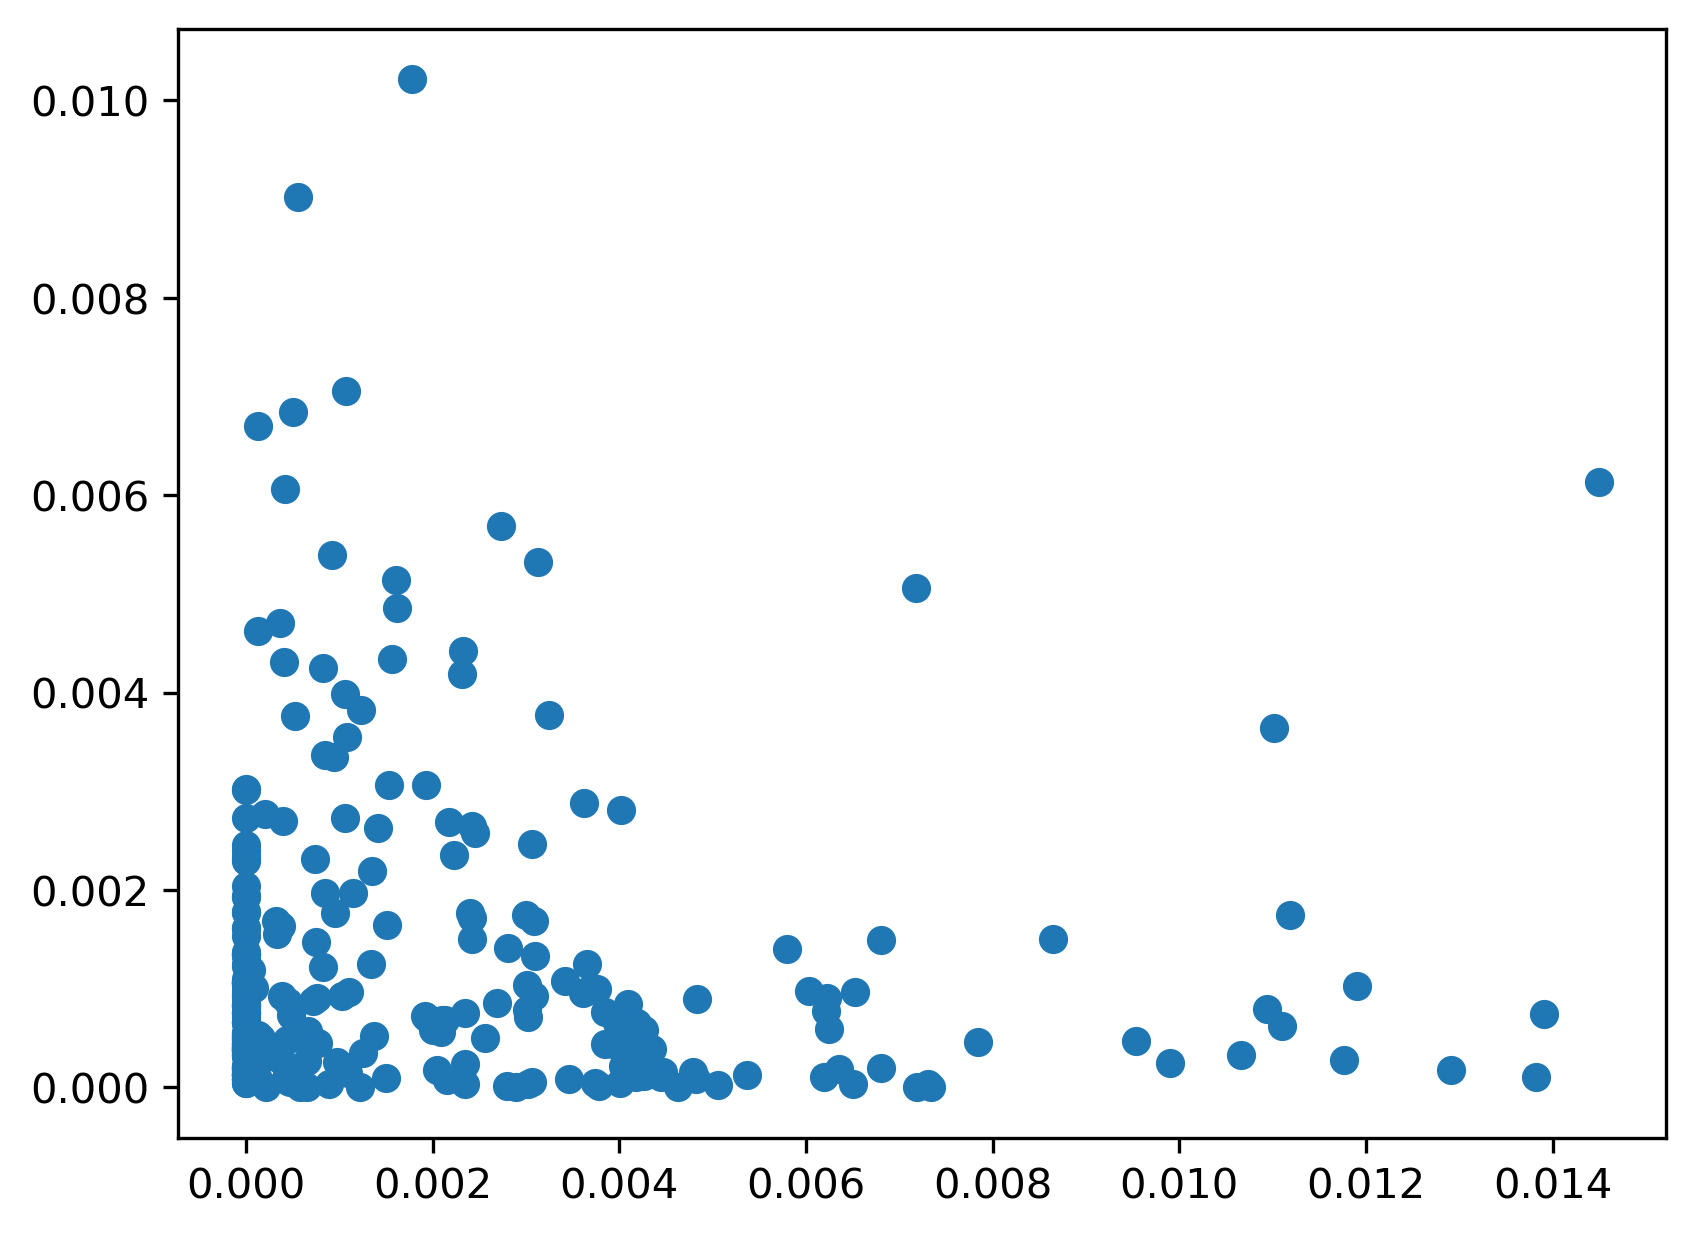

In [7]:
mgm_plot = format_mergegram(mergegram, delete_infinite=True)

fig, ax = plt.subplots(1,1, dpi=300)
ax.scatter(mgm_plot[:,0], mgm_plot[:,1] - mgm_plot[:,0])

# Check via Rips Complex

If we take the RipsComplex from Gudhi and compute all of its simplices, i.e., to the highest dimension the facegram of it should coincide with the cliquegram for a given distance matrix. 

We are looking at it for very few data points, since gudhi will otherwise be very slow.

In [8]:
X = np.random.random((20, 2))

distancematrix = pairwise_distances(X)
distancematrix = (distancematrix + distancematrix.T) / 2

In [9]:
st = gd.RipsComplex(distance_matrix=distancematrix, max_edge_length=np.max(distancematrix)).\
    create_simplex_tree(max_dimension=np.shape(distancematrix)[0])

In [10]:
mergegram = facegram_from_simplexTree(st, num_taxa=np.shape(distancematrix)[0], tqdm_disable=False)
mgm_rips = format_mergegram(mergegram, delete_infinite=True)

100%|██████████| 1048575/1048575 [00:09<00:00, 110849.72it/s]


In [11]:
mergegram_clique = Cliquegram(distancematrix=distancematrix).compute_mergegram()
mgm_clique  = format_mergegram(mergegram_clique, delete_infinite=True)

In [12]:
print('Are the mergegram of the facegram of the Rips and the mergegram of the cliquegram the same?')
print(np.all(mgm_rips == mgm_clique))

Are the mergegram of the facegram of the Rips and the mergegram of the cliquegram the same?
True
